Read csv and split for replicates

In [174]:
# plot style
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

In [175]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from uncertainties import umath

def subset_data_to_replicates(data_folder, larger=True):
    # use peaks of triangular voltage to subset replicates

    # CH2 is applied voltage, CH1 is result from photodiode
    digit = [char for char in data_folder if (char.isdigit() and char!="0")] # correct file digit
    digit = "0" if len(digit)==0 else digit[0]
    df_CH2 = pd.read_csv(str(data_folder + "F000"+digit+"CH2.CSV"), delimiter=",", header=0,
                         names=["info_1", "info_2", "empty_1", "time", "value", "empty_2"])
    df_CH1 = pd.read_csv(str(data_folder + "F000"+digit+"CH1.CSV"), delimiter=",", header=0,
                         names=["info_1", "info_2", "empty_1", "time", "value", "empty_2"])

    # find points where voltage changes incline/decline
    maxima = sp.signal.find_peaks(df_CH2["value"], distance=500)[0]
    minima = sp.signal.find_peaks(-df_CH2["value"], distance=500)[0]
    split_points = np.sort(np.concatenate((maxima, minima)))

    print("plot of splits")
    plt.plot(df_CH2["time"], df_CH2["value"], label="CH2")
    plt.plot(df_CH1["time"], df_CH1["value"], label="CH1")
    plt.scatter(df_CH2["time"][split_points], df_CH2["value"][split_points])
    plt.scatter(df_CH1["time"][split_points], df_CH1["value"][split_points])
    plt.legend()
    plt.ylabel("Voltage / V")
    plt.xlabel("Time / s")
    plt.show()

    # dataframe with all subsets combined
    combined_df = pd.DataFrame()

    for i in range(np.shape(split_points)[0]-1):

        # subset interval between split points
        interval_length = split_points[i+1]+1 - split_points[i]
        subset_time = df_CH2["time"][split_points[0]:split_points[0]+interval_length]
        subset_CH2 = df_CH2["value"][split_points[i]:split_points[i+1]+1]
        subset_CH1 = df_CH1["value"][split_points[i]:split_points[i+1]+1]

        # check if voltage is increasing/decreasing over time
        if larger ==True:
            a = subset_CH2.iloc[0]
            b = subset_CH2.iloc[-1]
        else:
            a = -subset_CH2.iloc[0]
            b = -subset_CH2.iloc[-1]

        if a < b:
            # relic from flipping to combine up/down
            #subset_CH2 = subset_CH2[::-1]
            #subset_CH1 = subset_CH1[::-1]

            # reset indices
            subset_time = subset_time.reset_index(drop=True)
            subset_CH2 = subset_CH2.reset_index(drop=True)
            subset_CH1 = subset_CH1.reset_index(drop=True)

            # create dataframe of subsets
            subset_df = pd.DataFrame({
                'time': subset_time,
                'CH2_value': subset_CH2,
                'CH1_value': subset_CH1
            })

            # append to combined dataframe
            combined_df = pd.concat([combined_df, subset_df])

    # sort appended values according to time
    combined_df = combined_df.reset_index(drop=True)
    combined_df = combined_df.sort_values(by="time")

    return(combined_df)

plot of splits


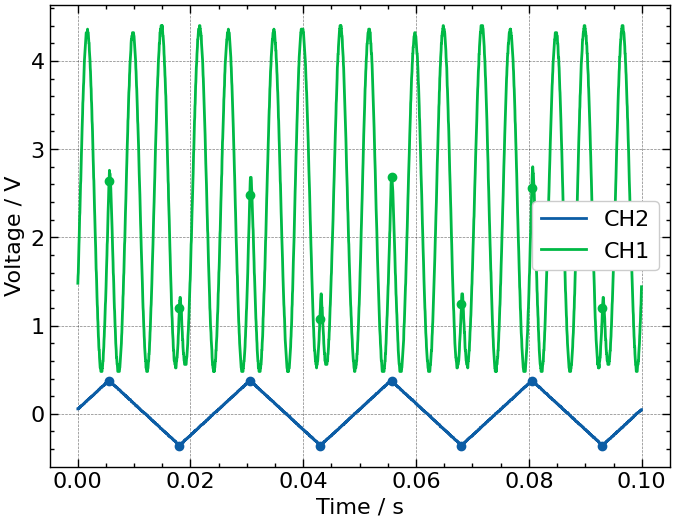

plot of replicate data
linear fit
a: 58.83826 +/- 0.034084 b: -0.68731 +/- 0.000422
cos^2 fit
a: 3.863285 +/- 0.008924 p: 1.574099 +/- 0.001145 vp: 149.467648 +/- 0.075724 y: 0.484796 +/- 0.004994


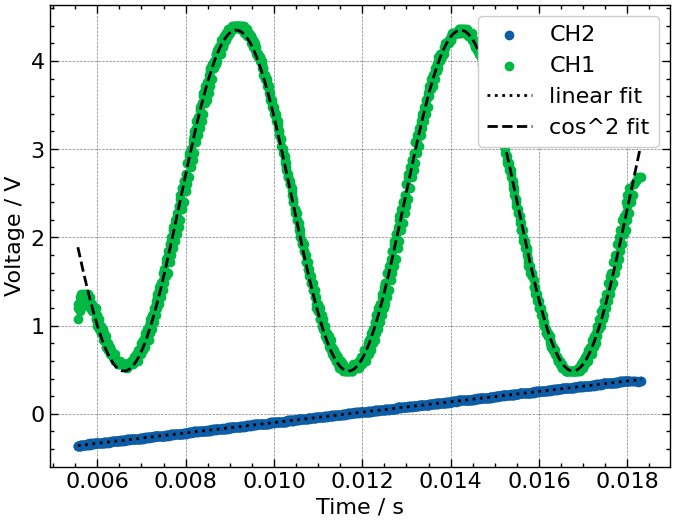

Vp propagated: (-1.31+/-0.07)e+04 Vp from fit: 149.47+/-0.08
r33: 71.3+/-1.8 pm/V


In [183]:
# analysis for horizontal polarization
data = subset_data_to_replicates("ALL0001_horizontal_pol/")

# plot result, see systematic deviation between flipped and unflipped
print("plot of replicate data")
plt.scatter(data["time"], data["CH2_value"], label="CH2")
plt.scatter(data["time"], data["CH1_value"], label="CH1")

# compute fits over replicate data
print("linear fit")
def line(t,a,b): return a*t+b
popt_1, pcov_1 = sp.optimize.curve_fit(line, data["time"], data["CH2_value"])
popt, pcov_sqr = np.round(popt_1, decimals=6), np.round(np.sqrt(np.diag(pcov_1)), decimals=6)
print("a:", popt[0], "+/-", pcov_sqr[0], "b:", popt[1], "+/-", pcov_sqr[1])

t = data["time"]#np.linspace(data["time"].iloc[0], data["time"].iloc[-1], len(data["CH2_value"]))
voltage_EOM=line(t, popt_1[0], popt_1[1])
plt.plot(t, voltage_EOM, "k:", label="linear fit")

print("cos^2 fit")
def transmittance(v,a,p,vp,y): return a*np.cos(p-np.pi/2/vp*v)**2+y
initial = [4, 1.6, 140, 0.5]
popt_2, pcov_2 = sp.optimize.curve_fit(transmittance, voltage_EOM*1000, data["CH1_value"], p0=initial)
popt, pcov_sqr = np.round(popt_2, decimals=6), np.round(np.sqrt(np.diag(pcov_2)), decimals=6)
print("a:", popt[0], "+/-", pcov_sqr[0], "p:", popt[1], "+/-", pcov_sqr[1],
      "vp:", popt[2], "+/-", pcov_sqr[2], "y:", popt[3], "+/-", pcov_sqr[3])

plt.plot(t, transmittance(voltage_EOM*1000, popt_2[0],popt_2[1],popt_2[2],popt_2[3]), "k--", label=r"cos^2 fit")
plt.legend()
plt.ylabel("Voltage / V")
plt.xlabel("Time / s")
plt.show()

# compute propagated uncertainty of vp incorporating the uncertainty of the linear fit (doesnt work yet)
# parameters from linear fit
a_l, b_l = ufloat(popt_1[0], np.sqrt(pcov_1[0,0])), ufloat(popt_1[1], np.sqrt(pcov_1[1,1]))
a_t, p_t = ufloat(popt_2[0], np.sqrt(pcov_2[0,0])),ufloat(popt_2[1], np.sqrt(pcov_2[1,1]))
vp_t, y_t = ufloat(popt_2[2], np.sqrt(pcov_2[2,2])),ufloat(popt_2[3], np.sqrt(pcov_2[3,3]))


voltage_uncert = line(0.0065, a_l, b_l)
def transmittance(v,a,p,vp,y): return a*umath.cos(p-np.pi/2/vp*v)**2+y
T_uncert = transmittance(voltage_uncert.n*1000, a_t, p_t, vp_t, y_t)
vp_uncert = np.pi/2*voltage_uncert*1000/(p_t - umath.acos(umath.sqrt(T_uncert - y_t)/a_t))

#print(T_uncert, voltage_uncert)
print("Vp propagated:", vp_uncert, "Vp from fit:", vp_t)
vp = vp_t # use fit uncertainty for now

# calculate r13 for horizontal/extraordinary
L=ufloat(4.45, 0.02) #mm
d=ufloat(0.8, 0.02) #mm
ne=2.2022
lam=633 # nm
print("r33:", d/L * lam/vp/ne**3 * 1e3, "pm/V")


plot of splits


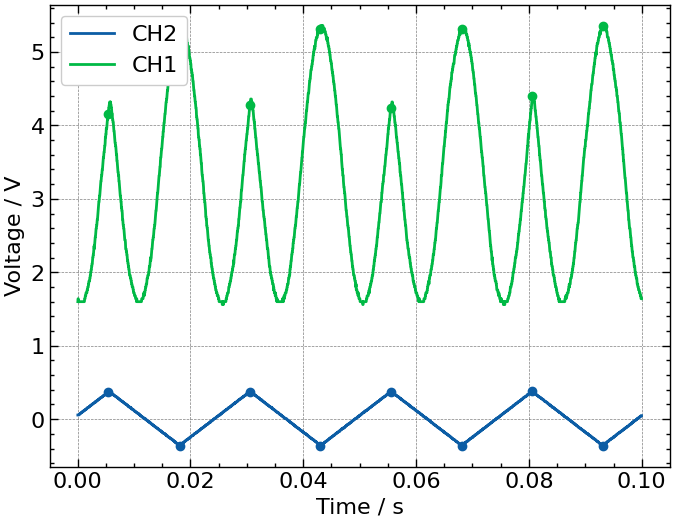

plot of replicate data
linear fit
a: 58.878158 +/- 0.031994 b: -0.678493 +/- 0.000391
cos^2 fit
a: 3.830426 +/- 0.004944 p: 1.882296 +/- 0.000609 vp: 446.471864 +/- 0.588156 y: 1.548929 +/- 0.002236


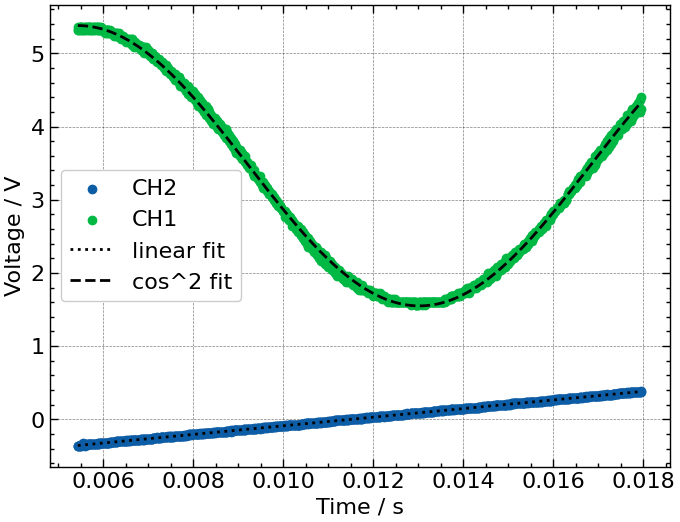

Vp propagated: -557.3+/-1.0 Vp from fit: 446.5+/-0.6
r13: 21.3+/-0.5 pm/V


In [185]:
# analysis for horizontal polarization
data = subset_data_to_replicates("ALL0002_waveplate_45_so_vertical/")

# plot result, see systematic deviation between flipped and unflipped
print("plot of replicate data")
plt.scatter(data["time"], data["CH2_value"], label="CH2")
plt.scatter(data["time"], data["CH1_value"], label="CH1")

# compute fits over replicate data
print("linear fit")
def line(t,a,b): return a*t+b
popt_1, pcov_1 = sp.optimize.curve_fit(line, data["time"], data["CH2_value"])
popt, pcov_sqr = np.round(popt_1, decimals=6), np.round(np.sqrt(np.diag(pcov_1)), decimals=6)
print("a:", popt[0], "+/-", pcov_sqr[0], "b:", popt[1], "+/-", pcov_sqr[1])

t = data["time"]#np.linspace(data["time"].iloc[0], data["time"].iloc[-1], len(data["CH2_value"]))
voltage_EOM=line(t, popt_1[0], popt_1[1])
plt.plot(t, voltage_EOM, "k:", label="linear fit")

print("cos^2 fit")
def transmittance(v,a,p,vp,y): return a*np.cos(p-np.pi/2/vp*v)**2+y
initial = [6, 1.6, 400, 0.5]
popt_2, pcov_2 = sp.optimize.curve_fit(transmittance, voltage_EOM*1000, data["CH1_value"], p0=initial)
popt, pcov_sqr = np.round(popt_2, decimals=6), np.round(np.sqrt(np.diag(pcov_2)), decimals=6)
print("a:", popt[0], "+/-", pcov_sqr[0], "p:", popt[1], "+/-", pcov_sqr[1],
      "vp:", popt[2], "+/-", pcov_sqr[2], "y:", popt[3], "+/-", pcov_sqr[3])

plt.plot(t, transmittance(voltage_EOM*1000, popt_2[0],popt_2[1],popt_2[2],popt_2[3]), "k--", label=r"cos^2 fit")
plt.legend()
plt.ylabel("Voltage / V")
plt.xlabel("Time / s")
plt.show()

# compute propagated uncertainty of vp incorporating the uncertainty of the linear fit (doesnt work yet)
# parameters from linear fit
a_l, b_l = ufloat(popt_1[0], np.sqrt(pcov_1[0,0])), ufloat(popt_1[1], np.sqrt(pcov_1[1,1]))
a_t, p_t = ufloat(popt_2[0], np.sqrt(pcov_2[0,0])),ufloat(popt_2[1], np.sqrt(pcov_2[1,1]))
vp_t, y_t = ufloat(popt_2[2], np.sqrt(pcov_2[2,2])),ufloat(popt_2[3], np.sqrt(pcov_2[3,3]))


voltage_uncert = line(0.0065, a_l, b_l)
def transmittance(v,a,p,vp,y): return a*umath.cos(p-np.pi/2/vp*v)**2+y
T_uncert = transmittance(voltage_uncert.n*1000, a_t, p_t, vp_t, y_t)
vp_uncert = np.pi/2*voltage_uncert*1000/(p_t - umath.acos(umath.sqrt(T_uncert - y_t)/a_t))

#print(T_uncert, voltage_uncert)
print("Vp propagated:", vp_uncert, "Vp from fit:", vp_t)
vp = vp_t # use fit uncertainty for now

# calculate r13 for vertical/ordinary
L=ufloat(4.45, 0.02) #mm
d=ufloat(0.8, 0.02) #mm
n0=2.2865
lam=633 # nm
print("r13:", d/L * lam/vp/n0**3 * 1e3, "pm/V")

plot of splits


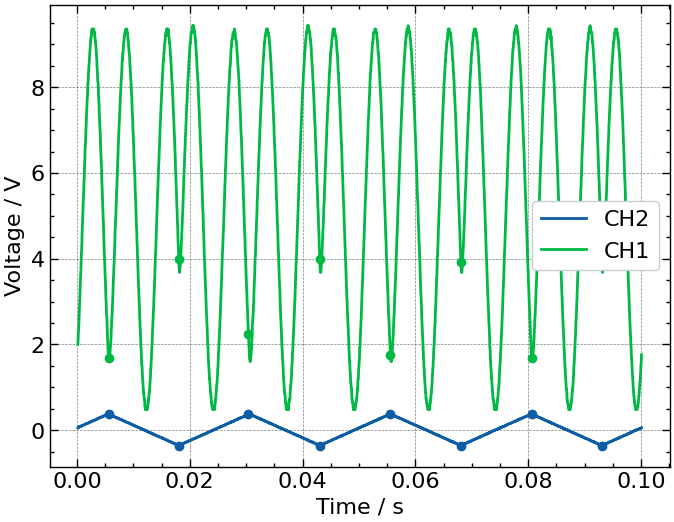

plot of replicate data
linear fit
a: 58.856344 +/- 0.029672 b: -0.697215 +/- 0.000372
cos^2 fit
a: 8.805402 +/- 0.014747 p: 1.587759 +/- 0.000748 vp: 215.569683 +/- 0.101049 y: 0.525226 +/- 0.009937


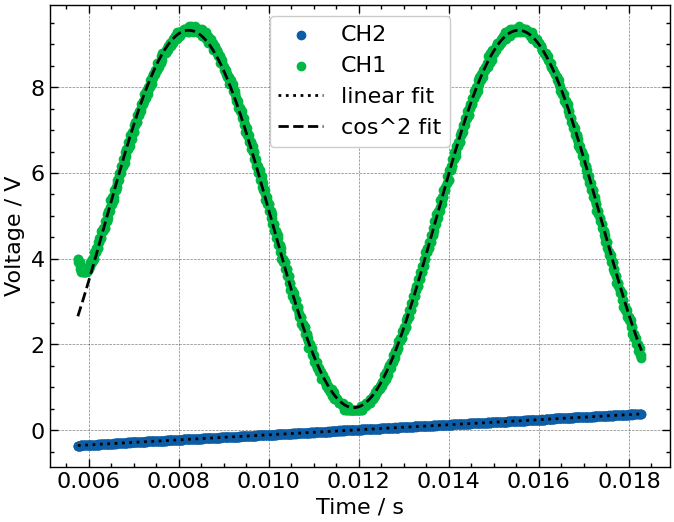

Vp propagated: -1839+/-5 Vp from fit: 215.57+/-0.10


In [178]:
# analysis for setup with polarizers
data = subset_data_to_replicates("ALL0004_switch_polarizers/")

# plot result, see systematic deviation between flipped and unflipped
print("plot of replicate data")
plt.scatter(data["time"], data["CH2_value"], label="CH2")
plt.scatter(data["time"], data["CH1_value"], label="CH1")

# compute fits over replicate data
print("linear fit")
def line(t,a,b): return a*t+b
popt_1, pcov_1 = sp.optimize.curve_fit(line, data["time"], data["CH2_value"])
popt, pcov_sqr = np.round(popt_1, decimals=6), np.round(np.sqrt(np.diag(pcov_1)), decimals=6)
print("a:", popt[0], "+/-", pcov_sqr[0], "b:", popt[1], "+/-", pcov_sqr[1])

t = data["time"]#np.linspace(data["time"].iloc[0], data["time"].iloc[-1], len(data["CH2_value"]))
voltage_EOM=line(t, popt_1[0], popt_1[1])
plt.plot(t, voltage_EOM, "k:", label="linear fit")

print("cos^2 fit")
def transmittance(v,a,p,vp,y): return a*np.cos(p-np.pi/2/vp*v)**2+y
initial = [8, 1.6, 200, 0.5]
popt_2, pcov_2 = sp.optimize.curve_fit(transmittance, voltage_EOM*1000, data["CH1_value"], p0=initial)
popt, pcov_sqr = np.round(popt_2, decimals=6), np.round(np.sqrt(np.diag(pcov_2)), decimals=6)
print("a:", popt[0], "+/-", pcov_sqr[0], "p:", popt[1], "+/-", pcov_sqr[1],
      "vp:", popt[2], "+/-", pcov_sqr[2], "y:", popt[3], "+/-", pcov_sqr[3])

plt.plot(t, transmittance(voltage_EOM*1000, popt_2[0],popt_2[1],popt_2[2],popt_2[3]), "k--", label=r"cos^2 fit")
plt.legend()
plt.ylabel("Voltage / V")
plt.xlabel("Time / s")
plt.show()

# compute propagated uncertainty of vp incorporating the uncertainty of the linear fit (doesnt work yet)
# parameters from linear fit
a_l, b_l = ufloat(popt_1[0], np.sqrt(pcov_1[0,0])), ufloat(popt_1[1], np.sqrt(pcov_1[1,1]))
a_t, p_t = ufloat(popt_2[0], np.sqrt(pcov_2[0,0])),ufloat(popt_2[1], np.sqrt(pcov_2[1,1]))
vp_t, y_t = ufloat(popt_2[2], np.sqrt(pcov_2[2,2])),ufloat(popt_2[3], np.sqrt(pcov_2[3,3]))


voltage_uncert = line(0.0065, a_l, b_l)
def transmittance(v,a,p,vp,y): return a*umath.cos(p-np.pi/2/vp*v)**2+y
T_uncert = transmittance(voltage_uncert.n*1000, a_t, p_t, vp_t, y_t)
vp_uncert = np.pi/2*voltage_uncert*1000/(p_t - umath.acos(umath.sqrt(T_uncert - y_t)/a_t))

#print(T_uncert, voltage_uncert)
print("Vp propagated:", vp_uncert, "Vp from fit:", vp_t)

plot of splits


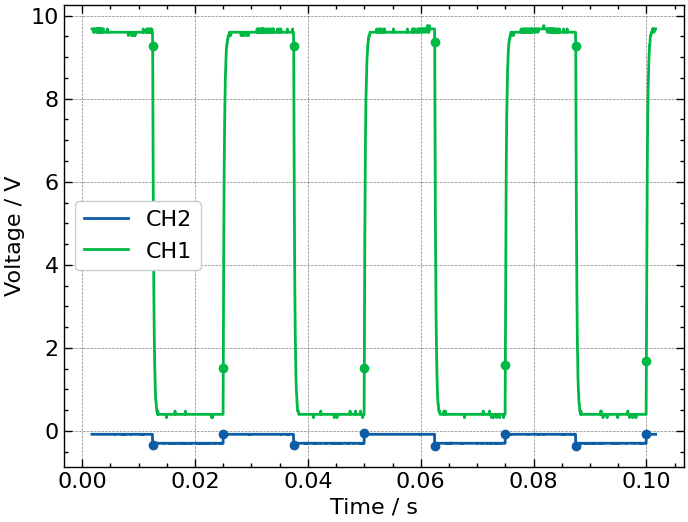

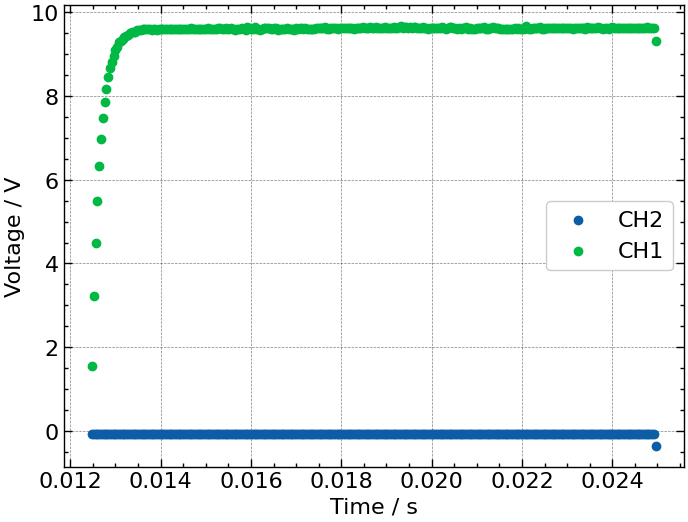

In [188]:
# plot of optical switch setup
data = subset_data_to_replicates("ALL0000_box_switch/", larger=False)

# average over values of the same time step
time = [np.average(data[data["time"]==step]["time"]) for step in np.unique(data["time"])]
ch1 = [np.average(data[data["time"]==step]["CH1_value"]) for step in np.unique(data["time"])]
ch2 = [np.average(data[data["time"]==step]["CH2_value"]) for step in np.unique(data["time"])]


plt.scatter(time, ch2, label="CH2")
plt.scatter(time, ch1, label="CH1")
plt.legend()
plt.ylabel("Voltage / V")
plt.xlabel("Time / s")
plt.show()